In [ ]:
# ===========================================================
# 1. Modelado de Grafos Espaciales – Cosine Similarity – SABER 11 (2015–2022)
# Autor: John Jairo Prado Piñeres
# Fecha: 2025
#
# Descripción:
# Este módulo construye, valida y exporta los grafos espaciales anuales derivadosde la base de datos SABER 11 (2015–2022). 
# Cada grafo representa relaciones de similitud entre departamentos, donde los nodos corresponden a departamentos y las aristas 
# se generan a partir de la similitud del coseno entre sus vectores de características agregadas por año.
#
# Este proceso constituye la primera etapa del pipeline espaciotemporal (Grafo -> GraphSAGE -> Embeddings -> LSTM -> Forecast -> Decoder).
#
# Flujo general:
# 1. Cargar los datos modelados (data/4_modelado)
# 2. Estandarizar variables numéricas por año (Z-score)
# 3. Codificar variables categóricas (OrdinalEncoder)
# 4. Agregar información al nivel departamental (promedio por departamento)
# 5. Calcular similitud del coseno entre departamentos
# 6. Crear aristas para pares con similitud > 0.60
# 7. Construir el grafo PyTorch Geometric (Data)
# 8. Guardar el archivo .pt por año en data/5_grafos/
# 9. Ejecutar validaciones automáticas (cantidad de nodos, aristas, NaN, simetría)
#
# Entradas:
# - Archivos CSV anuales limpios (formato *_completo.csv)
# - Variables originales del ICFES normalizadas y codificadas
#
# Salidas:
# - grafo_YYYY_deptos.pt : Objeto Data de PyTorch Geometric por año,
#                          listo para ser utilizado en el entrenamiento
#                          del modelo GraphSAGE (Notebook 2).
#
# Ventajas del enfoque:
# - Preserva la estructura espacial de la educación colombiana
# - Reduce dimensionalidad al nivel departamental
# - Elimina ruido individual de los estudiantes
# - Produce grafos consistentes y comparables entre años
# - Optimiza el entrenamiento del modelo GNN global
#
# Este Notebook representa la fase 1 del modelo espaciotemporal:
# (Datos → Grafo) y sienta las bases para el aprendizaje de embeddings
# anuales utilizados posteriormente en GraphSAGE, LSTM y Decoder.
# ===========================================================


# **IMPORTACIONES GENERALES**

In [31]:
!pip install networkx matplotlib pillow -q

In [1]:
# SCRIPT OFICIAL – SABER 11 (2015)
# Plantilla estandarizada para 2016–2022

import os
import random
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# Visualización
import matplotlib.pyplot as plt

# ML / Preprocesamiento
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import kneighbors_graph

# PyTorch / PyG
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

# ================================================================
# FUNCIÓN PARA REPRODUCIBILIDAD
# ================================================================

def set_seed(seed=5477976):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

set_seed(5477976)


# **Configuración de carpetas**

In [2]:
# Rutas actualizadas según tu estructura:
ruta_csv = r"C:/Users/john/Desktop/Saber_11_2025/data/4_modelado"
ruta_grafos = r"C:/Users/john/Desktop/Saber_11_2025/data/5_grafos"

os.makedirs(ruta_grafos, exist_ok=True)

# Años oficiales del proyecto
anios = list(range(2015, 2022 + 1))   # 2015–2022


# **Variables seleccionadas (features por nodo)**

In [3]:
vars_features = [
    "FAMI_EDUCACIONMADRE","FAMI_EDUCACIONPADRE","FAMI_PERSONASHOGAR",
    "FAMI_CUARTOSHOGAR","FAMI_ESTRATOVIVIENDA",
    "FAMI_TIENEAUTOMOVIL","FAMI_TIENECOMPUTADOR",
    "FAMI_TIENEINTERNET","FAMI_TIENELAVADORA",
    "PUNT_INGLES","PUNT_MATEMATICAS","PUNT_SOCIALES_CIUDADANAS",
    "PUNT_C_NATURALES","PUNT_LECTURA_CRITICA","PUNT_GLOBAL",
    "DESEMP_INGLES","ESTU_GENERO","COLE_BILINGUE"
]


# **Funciones auxiliares**

In [4]:
def buscar_archivo_anio(folder, year):
    for f in os.listdir(folder):
        if str(year) in f and f.endswith(".csv") and "completo" in f:
            return os.path.join(folder, f)
    return None


# **Unificar PERIODO**

In [5]:

def unificar_periodo(df, year):
    if "ANIO" in df.columns and "PERIODO" not in df.columns:
        df.rename(columns={"ANIO": "PERIODO"}, inplace=True)

    if "ANIO" in df.columns and "PERIODO" in df.columns:
        df.drop(columns=["ANIO"], inplace=True)

    if "PERIODO" not in df.columns:
        df["PERIODO"] = year

    df["PERIODO"] = df["PERIODO"].astype(str).str[:4].astype(int)
    return df

# **Codificar categóricas**

In [6]:
def codificar_categoricas(df):
    df2 = df.copy()
    cat_cols = df2.select_dtypes(include=["object"]).columns.tolist()

    if len(cat_cols) > 0:
        enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
        df2[cat_cols] = enc.fit_transform(df2[cat_cols])

    return df2


# **Normalizar numéricas Z-score por año**

In [7]:
def zscore_por_anio(df):
    df_norm = df.copy()
    columnas = df_norm.select_dtypes(include=[np.number]).columns.tolist()

    for year in df_norm["PERIODO"].unique():
        mask = df_norm["PERIODO"] == year
        sub = df_norm.loc[mask, columnas]

        medias = sub.mean()
        desv = sub.std().replace(0, 1)

        df_norm.loc[mask, columnas] = (sub - medias) / desv

    return df_norm

# **Crear Grafo por Departamento**

In [25]:
def crear_grafo(df, year):

    # 1. Agrupar por departamento
    df_dep = df.groupby("COLE_DEPTO_UBICACION")[vars_features].mean().reset_index()
    df_dep = df_dep.fillna(0)

    X_np = df_dep[vars_features].values
    X = torch.tensor(X_np, dtype=torch.float)

    # 2. Similaridad coseno
    sim = cosine_similarity(X_np)
    np.fill_diagonal(sim, 0)

    # 3. Conexiones por similitud (threshold)
    threshold_edges = np.argwhere(sim >= 0.40)

    # 4. kNN mínimo (2 vecinos garantizados por nodo)
    k = 2
    knn_edges = []
    for i in range(sim.shape[0]):
        vecinos = sim[i].argsort()[-k:]
        for v in vecinos:
            if i != v:
                knn_edges.append([i, v])

    # 5. Unificar aristas
    edges = np.vstack([threshold_edges, np.array(knn_edges)])

    # 6. Eliminar duplicados
    edges = np.unique(edges, axis=0)

    # 7. FORZAR SIMETRÍA (no dirigido) — PASO CLAVE
    edges_sym = np.vstack([edges, edges[:, [1, 0]]])
    edges = np.unique(edges_sym, axis=0)

    # 8. Crear grafo PyG
    edge_index = torch.tensor(edges.T, dtype=torch.long)

    g = Data(
        x=X,
        edge_index=edge_index,
        deptos=df_dep["COLE_DEPTO_UBICACION"].tolist(),
        year=year
    )

    return g


In [22]:
def crear_grafo(df, year):

    # 1. Agrupar por departamento
    df_dep = df.groupby("COLE_DEPTO_UBICACION")[vars_features].mean().reset_index()
    df_dep = df_dep.fillna(0)

    X_np = df_dep[vars_features].values
    X = torch.tensor(X_np, dtype=torch.float)

    # 2. Similaridad coseno
    sim = cosine_similarity(X_np)
    np.fill_diagonal(sim, 0)

    # 3. Threshold principal (sim ≥ 0.40)
    threshold_edges = np.argwhere(sim >= 0.40)

    # 4. kNN mínimo = 2 por nodo
    k = 2
    knn_edges = []
    for i in range(sim.shape[0]):
        # tomar los k más similares
        vecinos = sim[i].argsort()[-k:]
        for v in vecinos:
            if i != v:
                knn_edges.append([i, v])

    # 5. Unificar ambas fuentes de aristas
    edges = np.vstack([threshold_edges, np.array(knn_edges)])
    
    # 6. Eliminar duplicados
    edges = np.unique(edges, axis=0)

    # 7. Crear grafo
    edge_index = torch.tensor(edges.T, dtype=torch.long)

    g = Data(
        x=X,
        edge_index=edge_index,
        deptos=df_dep["COLE_DEPTO_UBICACION"].tolist(),
        year=year
    )

    return g


# **Pipeline: Procesar Años 2015–2022**

In [26]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics.pairwise import cosine_similarity

for year in anios:
    print(f"\n=== Procesando año {year} ===")

    archivo = buscar_archivo_anio(ruta_csv, year)
    if archivo is None:
        print(f"NO se encontró CSV para {year}")
        continue

    df = pd.read_csv(archivo, low_memory=False)

    df = unificar_periodo(df, year)
    df = codificar_categoricas(df)
    df = zscore_por_anio(df)

    g = crear_grafo(df, year)
    if g is None:
        continue

    out_file = os.path.join(ruta_grafos, f"grafo_{year}_deptos.pt")
    torch.save(g, out_file)

    print(f"Grafo {year} guardado → {out_file}")


=== Procesando año 2015 ===
Grafo 2015 guardado → C:/Users/john/Desktop/Saber_11_2025/data/5_grafos\grafo_2015_deptos.pt

=== Procesando año 2016 ===
Grafo 2016 guardado → C:/Users/john/Desktop/Saber_11_2025/data/5_grafos\grafo_2016_deptos.pt

=== Procesando año 2017 ===
Grafo 2017 guardado → C:/Users/john/Desktop/Saber_11_2025/data/5_grafos\grafo_2017_deptos.pt

=== Procesando año 2018 ===
Grafo 2018 guardado → C:/Users/john/Desktop/Saber_11_2025/data/5_grafos\grafo_2018_deptos.pt

=== Procesando año 2019 ===
Grafo 2019 guardado → C:/Users/john/Desktop/Saber_11_2025/data/5_grafos\grafo_2019_deptos.pt

=== Procesando año 2020 ===
Grafo 2020 guardado → C:/Users/john/Desktop/Saber_11_2025/data/5_grafos\grafo_2020_deptos.pt

=== Procesando año 2021 ===
Grafo 2021 guardado → C:/Users/john/Desktop/Saber_11_2025/data/5_grafos\grafo_2021_deptos.pt

=== Procesando año 2022 ===
Grafo 2022 guardado → C:/Users/john/Desktop/Saber_11_2025/data/5_grafos\grafo_2022_deptos.pt


# **Validador Automático**

# **Versión del Verificador**

In [27]:
def check_symmetry(edge_index):
    edges = set(tuple(e) for e in edge_index.t().tolist())
    reversed_edges = set((v, u) for (u, v) in edges)
    return edges == reversed_edges

def revisar_grafo(path):
    print(f"\nRevisando {os.path.basename(path)}")
    g = torch.load(path, weights_only=False)

    x = g.x
    ei = g.edge_index
    n = x.shape[0]

    print("Nodos:", n)
    print("Features por nodo:", x.shape[1])
    print("Aristas:", ei.shape[1])

    # 1. NaN en features
    print("¿NaN en x?:", torch.isnan(x).any().item())

    # 2. Revisar rangos
    print("Máximo por feature:", x.max().item())
    print("Mínimo por feature:", x.min().item())

    # 3. Aristas inválidas
    invalid = (ei < 0).any() or (ei >= n).any()
    print("¿Aristas inválidas?:", invalid)

    # 4. Nodos aislados
    grados = torch.bincount(ei[0], minlength=n)
    aislados = (grados == 0).sum().item()
    print("Nodos aislados:", aislados)

    # 5. Aristas duplicadas
    edges = [tuple(e) for e in ei.t().tolist()]
    duplicadas = len(edges) - len(set(edges))
    print("Aristas duplicadas:", duplicadas)

    # 6. Simetría
    print("¿Simétrico?:", check_symmetry(ei))

    print("----------------------------------")

# Ejecutar validador
for year in anios:
    path = os.path.join(ruta_grafos, f"grafo_{year}_deptos.pt")
    if os.path.exists(path):
        revisar_grafo(path)



Revisando grafo_2015_deptos.pt
Nodos: 33
Features por nodo: 18
Aristas: 482
¿NaN en x?: False
Máximo por feature: 1.2385485172271729
Mínimo por feature: -1.2623273134231567
¿Aristas inválidas?: tensor(False)
Nodos aislados: 0
Aristas duplicadas: 0
¿Simétrico?: True
----------------------------------

Revisando grafo_2016_deptos.pt
Nodos: 33
Features por nodo: 18
Aristas: 476
¿NaN en x?: False
Máximo por feature: 1.3024793863296509
Mínimo por feature: -1.3110016584396362
¿Aristas inválidas?: tensor(False)
Nodos aislados: 0
Aristas duplicadas: 0
¿Simétrico?: True
----------------------------------

Revisando grafo_2017_deptos.pt
Nodos: 33
Features por nodo: 18
Aristas: 440
¿NaN en x?: False
Máximo por feature: 1.1269694566726685
Mínimo por feature: -1.1456304788589478
¿Aristas inválidas?: tensor(False)
Nodos aislados: 0
Aristas duplicadas: 0
¿Simétrico?: True
----------------------------------

Revisando grafo_2018_deptos.pt
Nodos: 29
Features por nodo: 18
Aristas: 416
¿NaN en x?: False

# **carga tus grafos .pt, los convierte a NetworkX, y los dibuja con layout "spring"**

In [29]:
import torch
import networkx as nx
import matplotlib.pyplot as plt

def plot_grafo_anio(year):
    path = f"C:/Users/john/Desktop/Saber_11_2025/data/5_grafos/grafo_{year}_deptos.pt"
    
    # Cargar grafo
    g = torch.load(path, weights_only=False)
    ei = g.edge_index
    deptos = g.deptos

    # Crear grafo no dirigido
    G = nx.Graph()

    # Agregar nodos
    for i, dpto in enumerate(deptos):
        G.add_node(i, label=dpto)

    # Agregar aristas
    for u, v in ei.t().tolist():
        G.add_edge(u, v)

    # Dibujar
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42, k=0.30)  # layout bonito y estable
    
    nx.draw(G, pos, node_color="lightblue",
            node_size=800, linewidths=1, edge_color="gray", width=1.2)

    # Etiquetas
    labels = {i: deptos[i] for i in range(len(deptos))}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title(f"Grafo {year} - Departamentos", fontsize=14)
    plt.axis("off")
    plt.show()


# **Ver el grafo de un año específico**

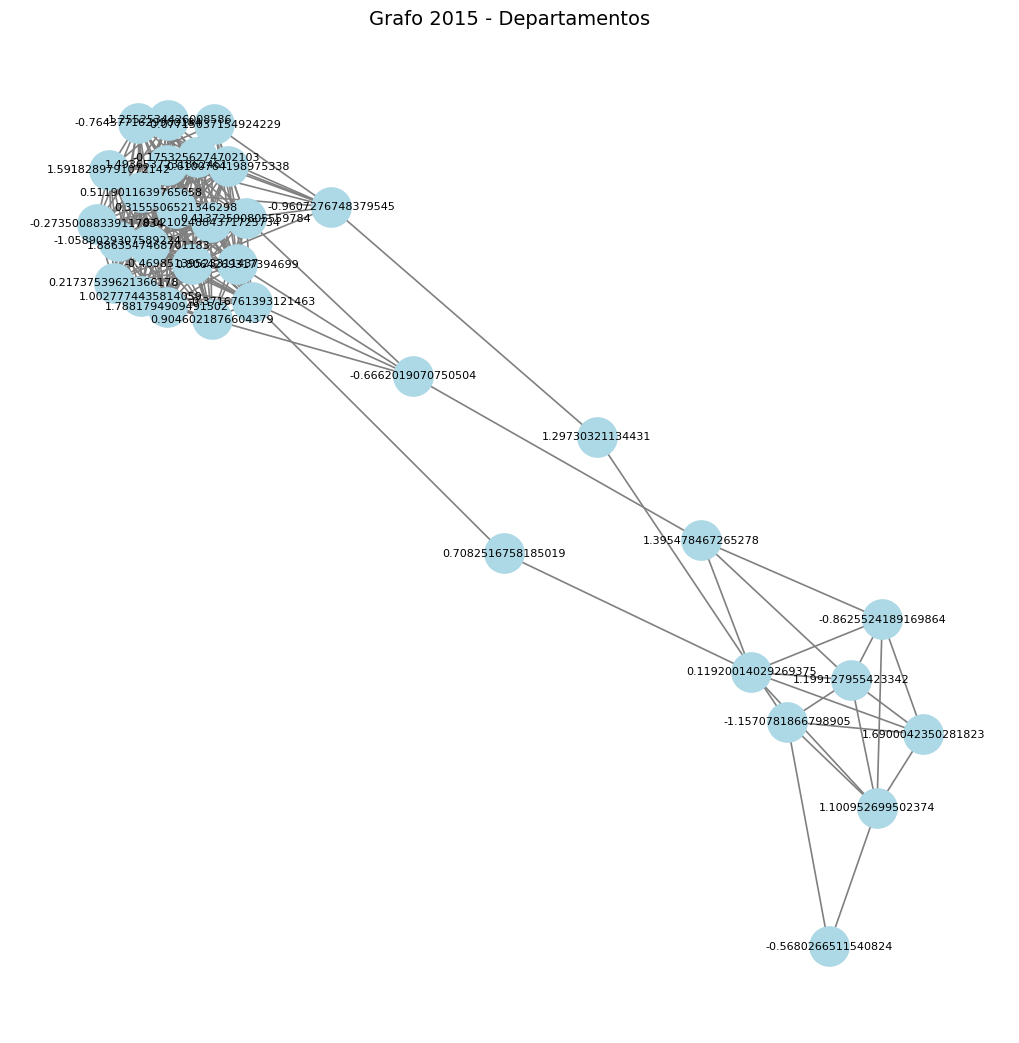

In [30]:
plot_grafo_anio(2015)

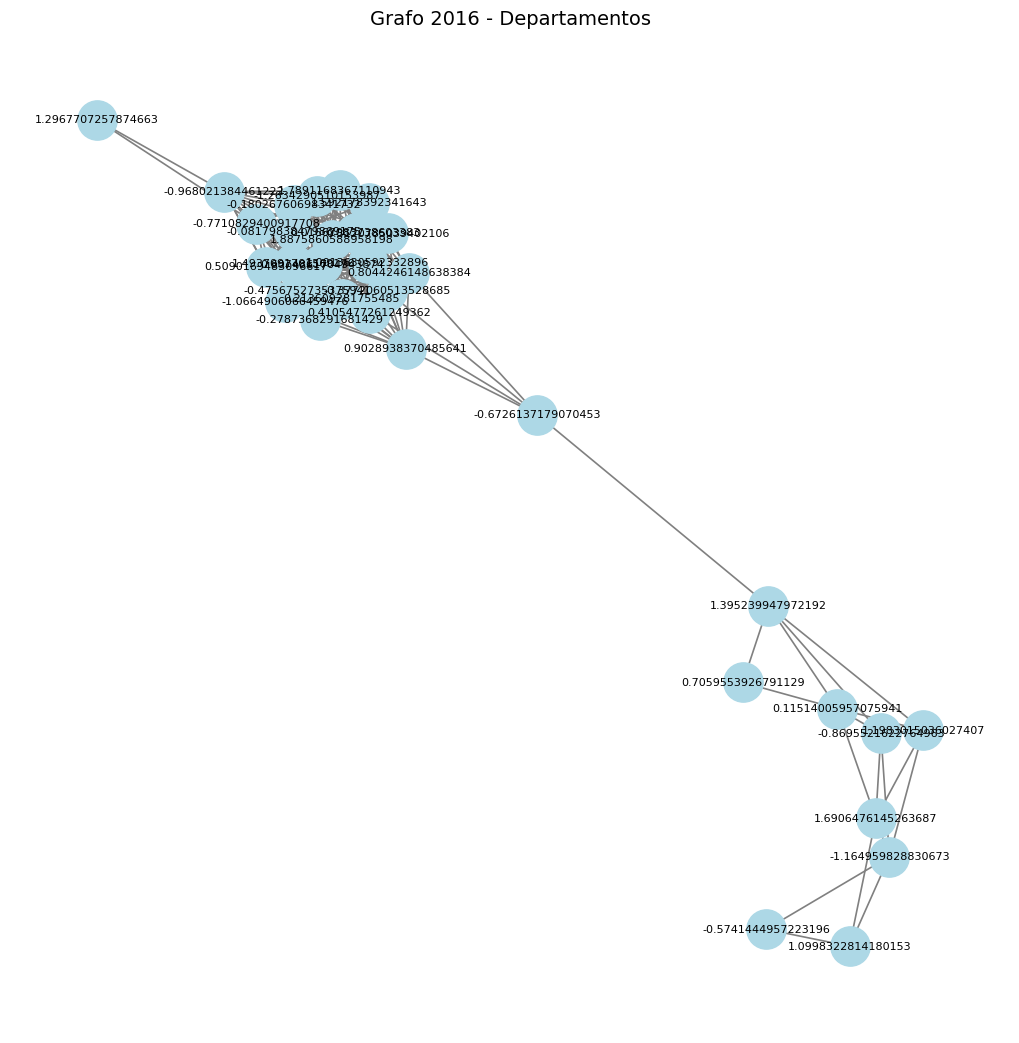

In [33]:
plot_grafo_anio(2016)

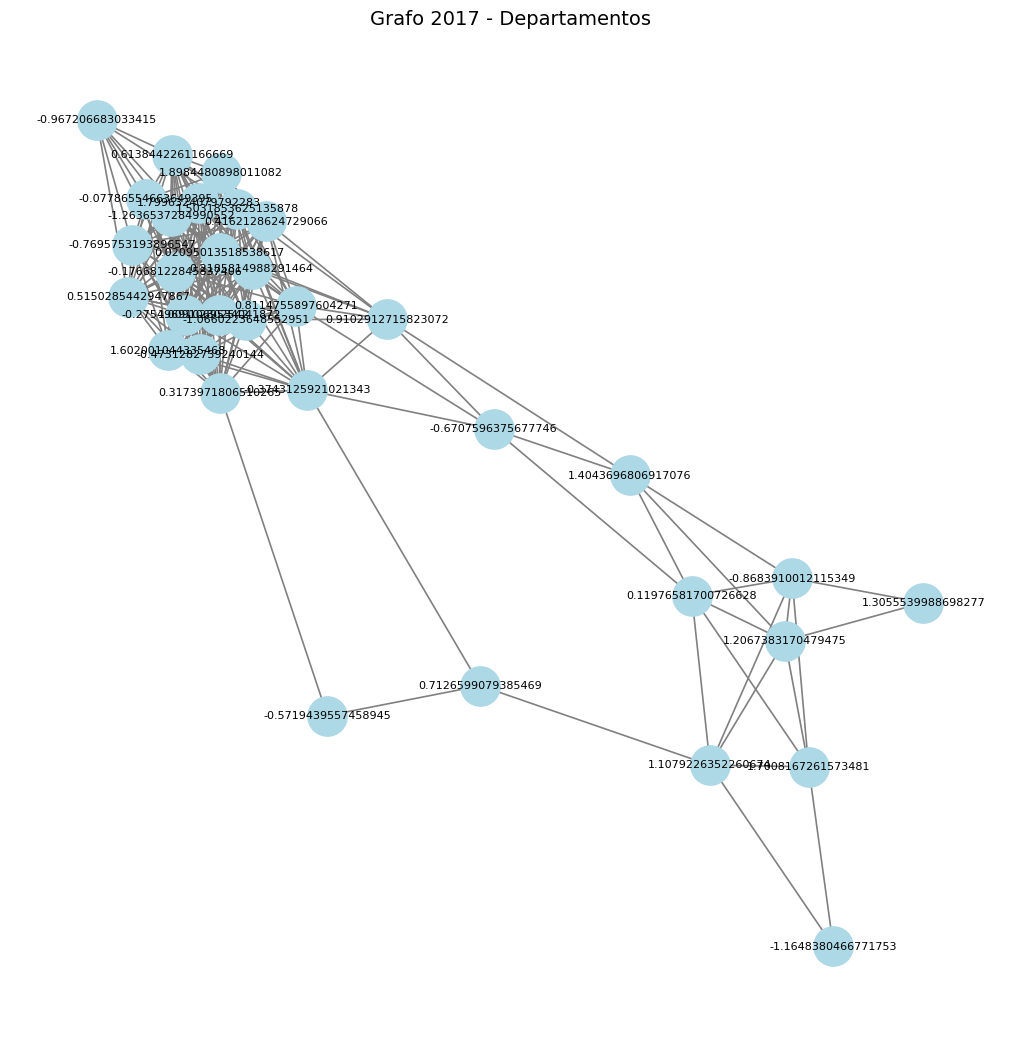

In [34]:
plot_grafo_anio(2017)

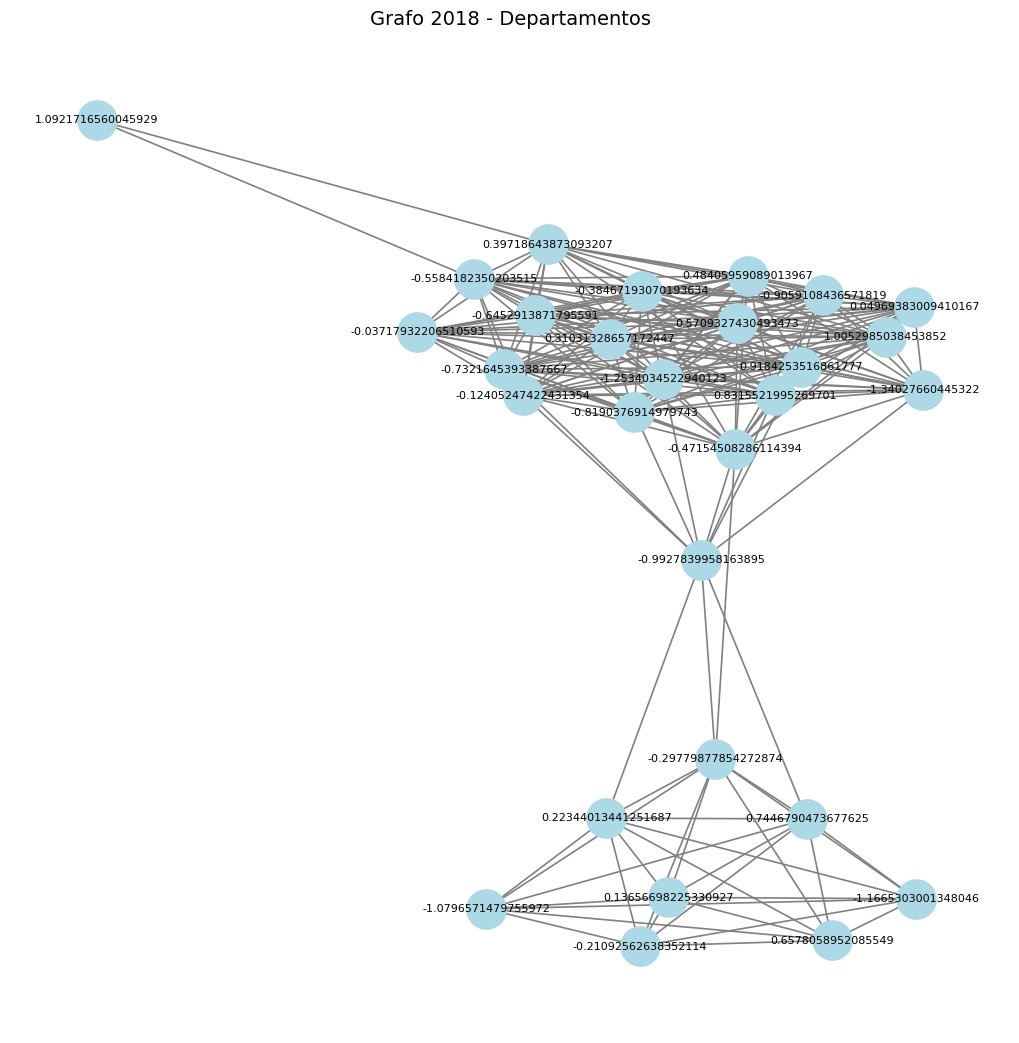

In [35]:
plot_grafo_anio(2018)

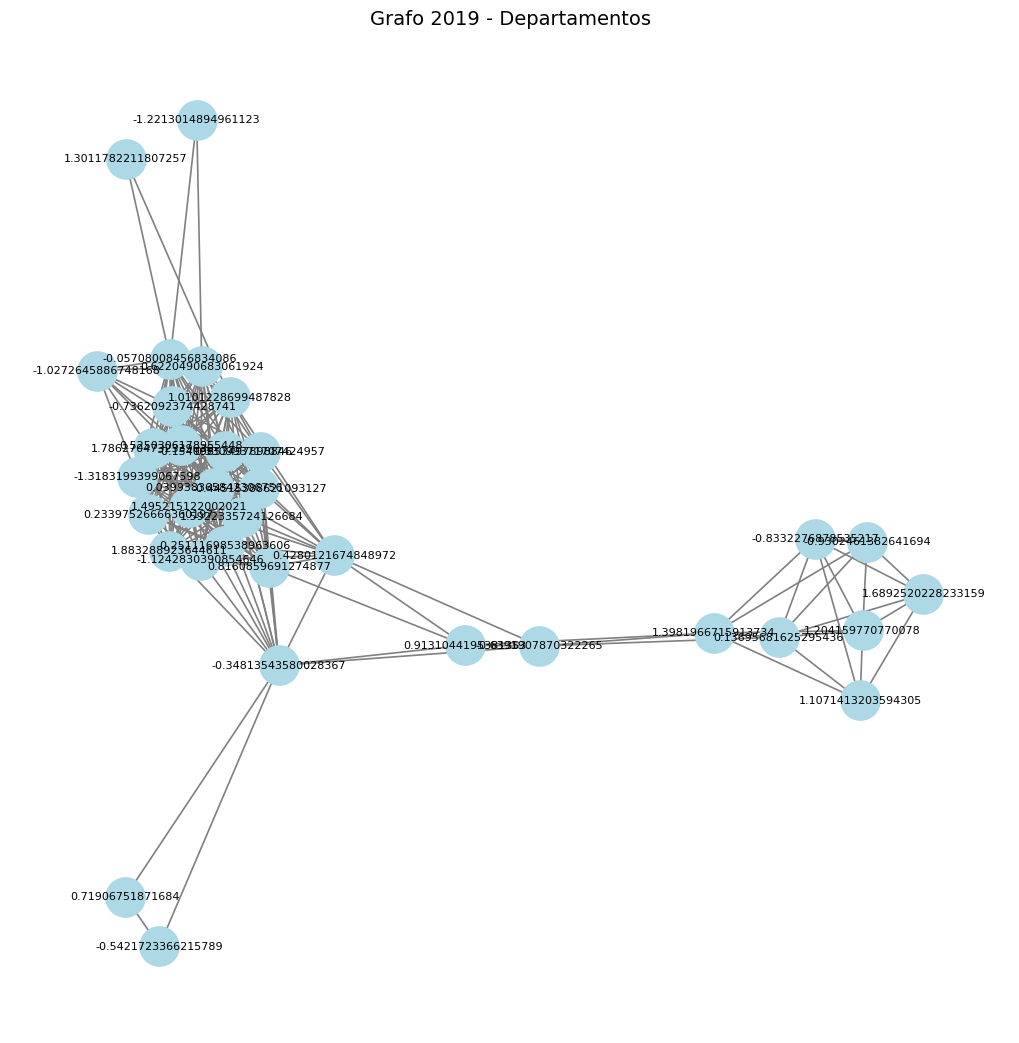

In [36]:
plot_grafo_anio(2019)

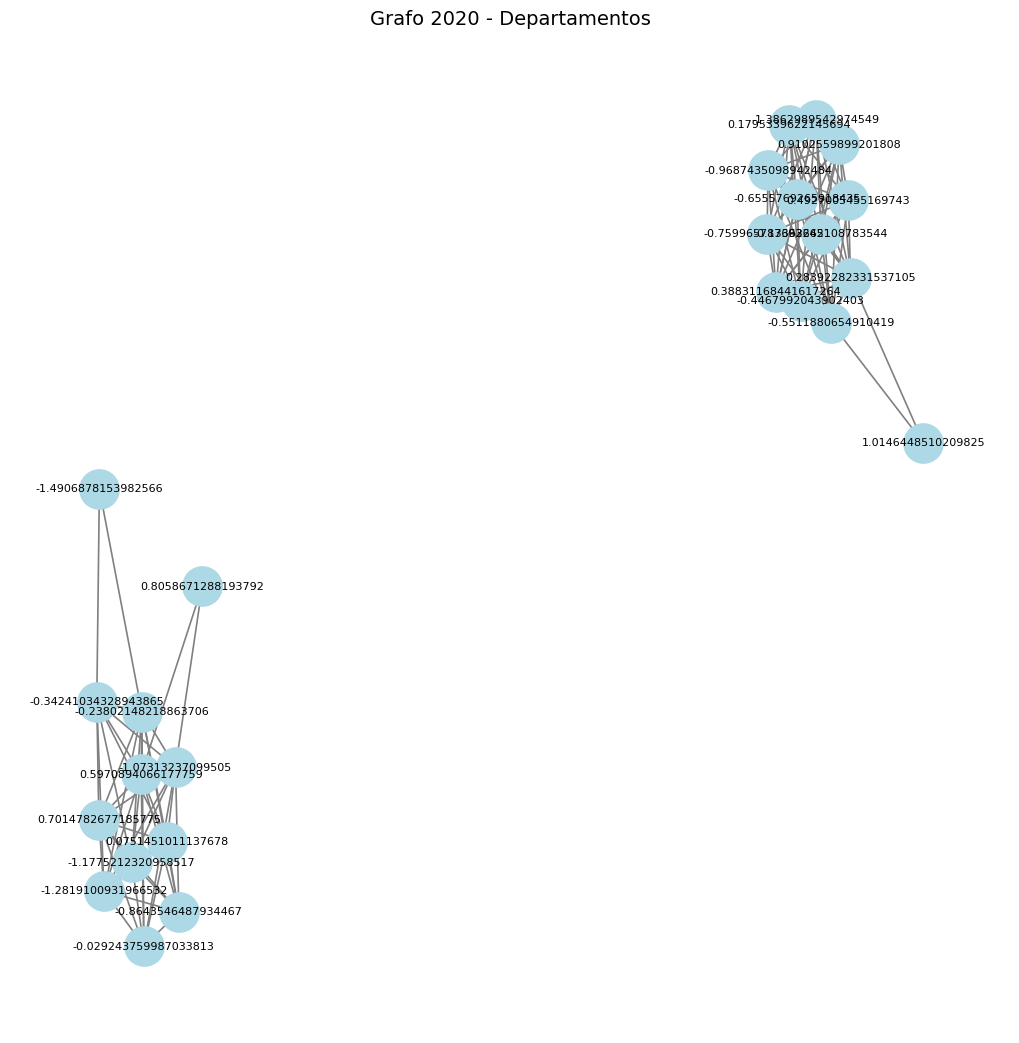

In [37]:
plot_grafo_anio(2020)

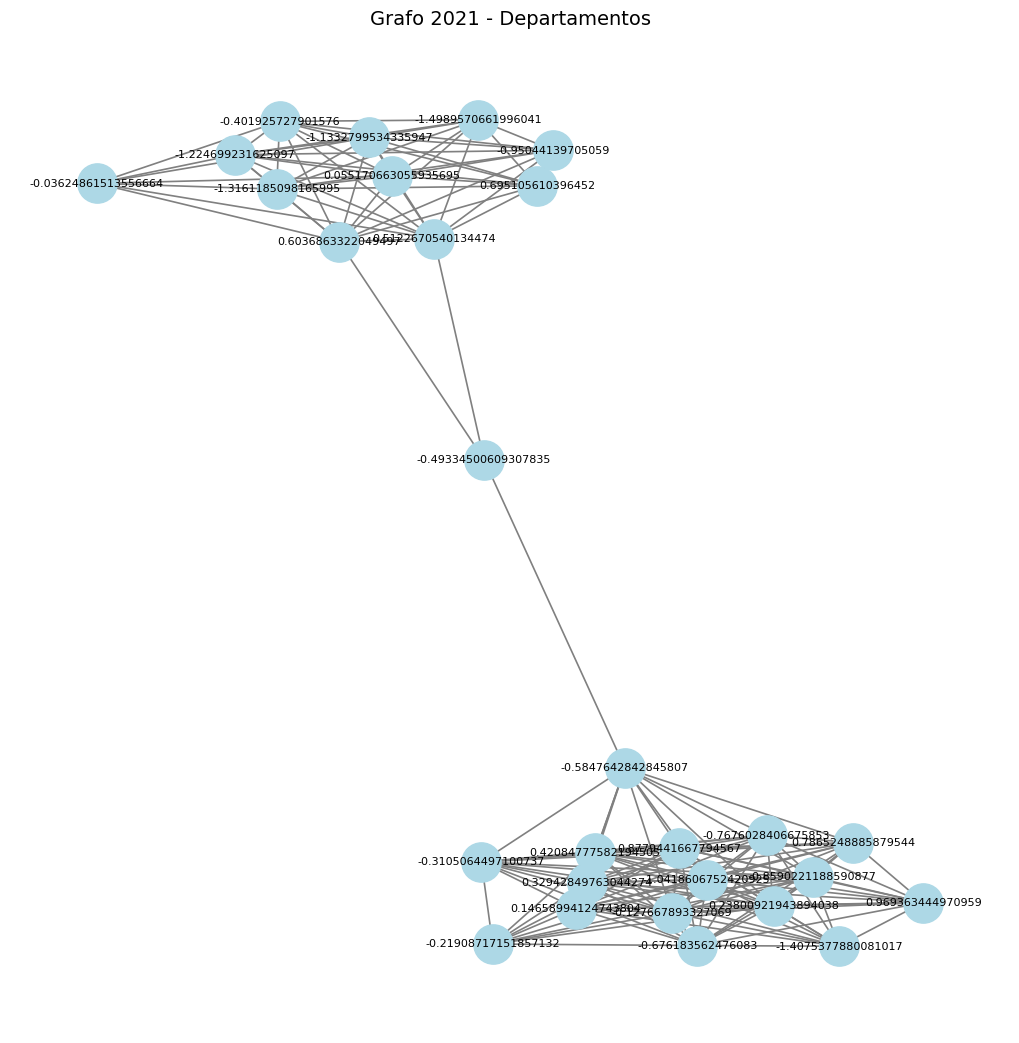

In [38]:
plot_grafo_anio(2021)

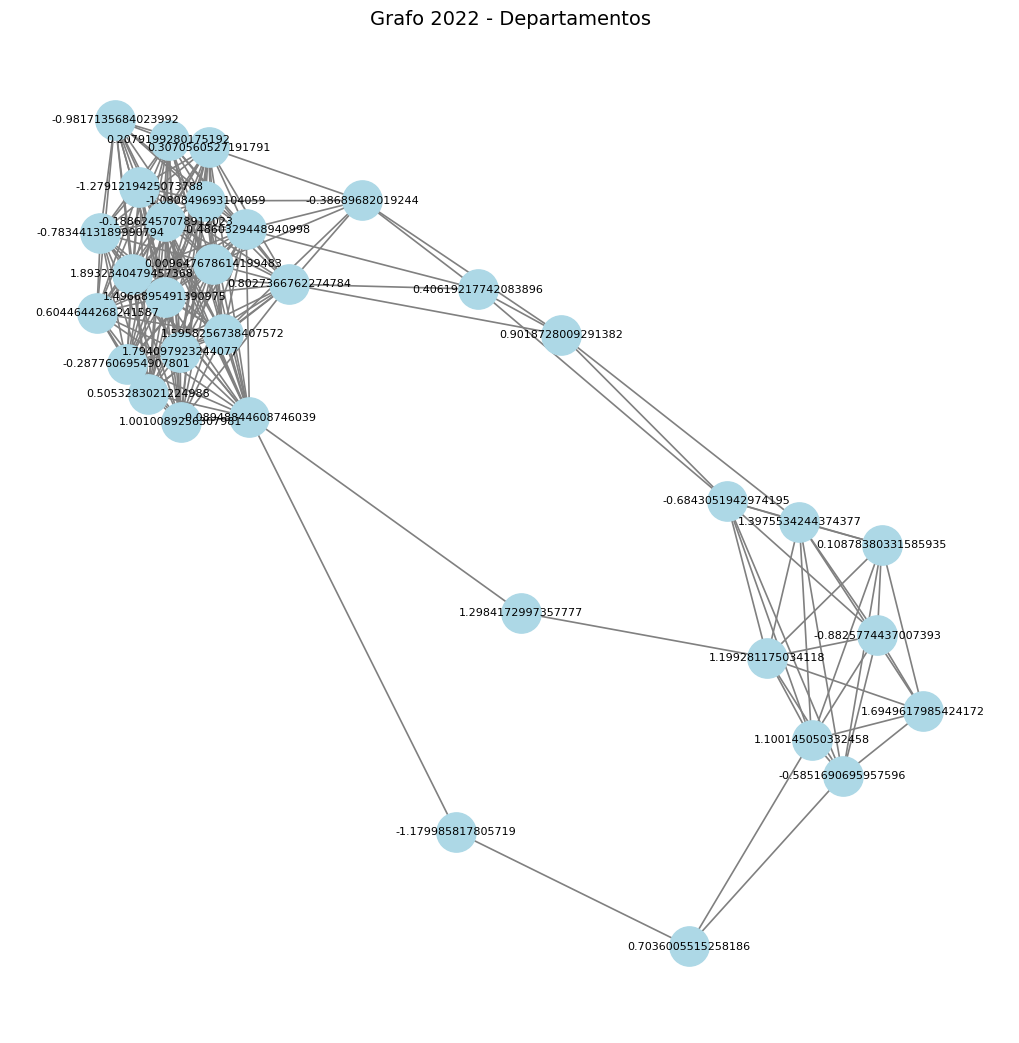

In [39]:
plot_grafo_anio(2022)

# **Código completo para generar el GIF animado**

In [32]:
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
from PIL import Image

# ======== CONFIGURACIÓN DE RUTAS ========
ruta_grafos = r"C:/Users/john/Desktop/Saber_11_2025/data/5_grafos"
save_folder = "animacion_grafos"
os.makedirs(save_folder, exist_ok=True)

# ======== FUNCIÓN PARA CONVERTIR UN GRAFO A IMAGEN PNG ========
def grafo_to_image(year):
    path = os.path.join(ruta_grafos, f"grafo_{year}_deptos.pt")

    # Cargar grafo
    g = torch.load(path, weights_only=False)
    ei = g.edge_index
    deptos = g.deptos

    # Crear grafo en NetworkX
    G = nx.Graph()
    for i, d in enumerate(deptos):
        G.add_node(i, label=d)
    for u, v in ei.t().tolist():
        G.add_edge(u, v)

    # Dibujar grafo
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, seed=42, k=0.28)

    nx.draw(
        G, pos,
        node_color="skyblue",
        node_size=850,
        edge_color="gray",
        width=1.2,
        with_labels=False
    )

    labels = {i: deptos[i] for i in range(len(deptos))}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

    plt.title(f"Grafo Saber 11 – {year}", fontsize=16)
    plt.axis("off")

    # Guardar imagen
    img_path = os.path.join(save_folder, f"grafo_{year}.png")
    plt.savefig(img_path, dpi=150, bbox_inches="tight")
    plt.close()

    return img_path

# ======== GENERAR IMÁGENES PARA CADA AÑO ========
imagenes = []
for year in range(2015, 2022 + 1):
    print(f"Generando imagen para {year} ...")
    img_file = grafo_to_image(year)
    imagenes.append(Image.open(img_file))

# ======== CREAR GIF FINAL ========
gif_path = "grafos_saber11_2015_2022.gif"
imagenes[0].save(
    gif_path,
    save_all=True,
    append_images=imagenes[1:],
    duration=900,  # milisegundos por frame (0.9 segundos)
    loop=0         # loop infinito
)

gif_path


Generando imagen para 2015 ...
Generando imagen para 2016 ...
Generando imagen para 2017 ...
Generando imagen para 2018 ...
Generando imagen para 2019 ...
Generando imagen para 2020 ...
Generando imagen para 2021 ...
Generando imagen para 2022 ...


'grafos_saber11_2015_2022.gif'

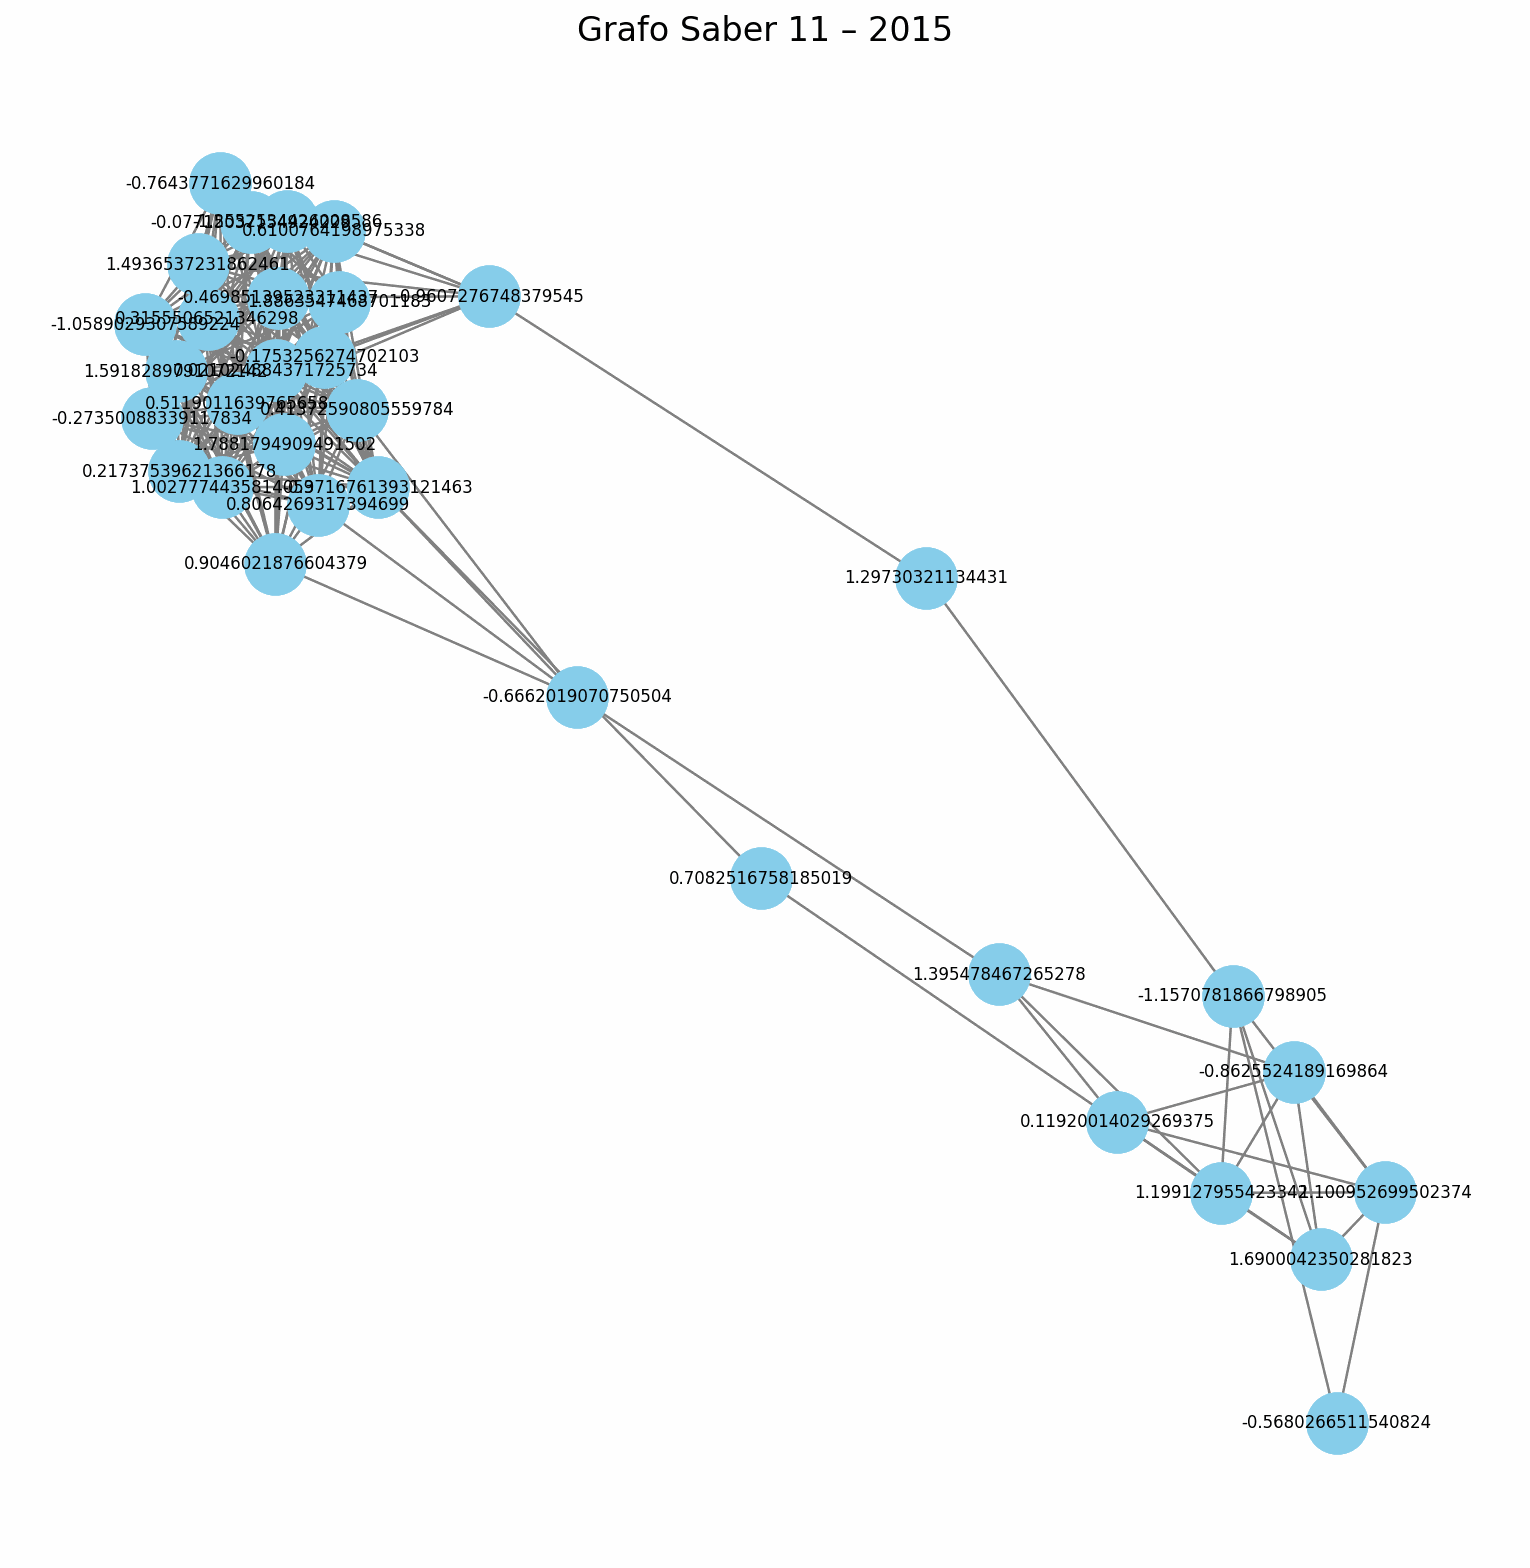

In [40]:
from IPython.display import Image
Image(filename="grafos_saber11_2015_2022.gif")
